In [1]:
!pip3 install torchvision
!pip3 install torch
from os.path import exists


import torchvision
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
import pickle
import PIL
from PIL import Image
import os
from tqdm.notebook import tqdm, trange

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from pathlib import Path
from torch.utils.data import DataLoader

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
NG_SEED = 9527
DATA_ROOT = '/kaggle/input/dogs-vs-cats'
WORK_ROOT = '/kaggle/working'
CKPT_PATH = f'{WORK_ROOT}/checkpoints/best.ckpt'
IMGS_ROOT = f'{WORK_ROOT}/temp_unzip'
SUBMITCSV = f'{WORK_ROOT}/submission.csv'

INPUT_SIZE = 224
BATCH_SIZE = 128
NUM_CLASSES = 2

MAX_EPOCHS = 3



In [4]:
import os
import zipfile
if not os.path.exists(f'{IMGS_ROOT}/train'):
    with zipfile.ZipFile(f'{DATA_ROOT}/train.zip', 'r') as z:
        z.extractall(f'{IMGS_ROOT}')
        


In [5]:
filenames = os.listdir(f'{IMGS_ROOT}/train')
label_ids = [fname[:3] for fname in filenames]
import pandas as pd
data = pd.DataFrame({'filename': filenames, 'label': label_ids})
data.head()


,filename,label
0,dog.11259.jpg,dog
1,dog.6374.jpg,dog
2,cat.8091.jpg,cat
3,dog.9536.jpg,dog
4,cat.1813.jpg,cat


<Axes: xlabel='label', ylabel='count'>

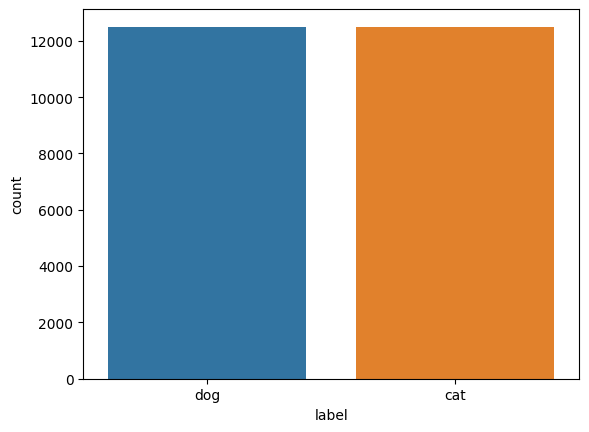

In [6]:
import seaborn as sns
sns.countplot(x='label',data=data)


In [7]:
class CatDogsDataSet(Dataset):
    def __init__(self, files, mode = ''):
        super().__init__()
        self.files = files
        self.mode = mode
        self.labels = [ path[:3] for path in self.files]
        self.l =  {'dog': 0, 'cat': 1}


                      
    def __len__(self):
        return len(self.files)
      
    def load_sample(self, file):
        image = Image.open(f'{IMGS_ROOT}/{self.mode}/{file}')
        image.load()
        return image
    
    def __getitem__(self, index):
        if self.mode == 'train': 
            transform = transforms.Compose([
              transforms.Resize(size=(224, 224)),
              transforms.ColorJitter(brightness=0.3, contrast=0.4),
              transforms.RandomHorizontalFlip(p=0.2),
              transforms.RandomVerticalFlip(p=0.1),
              transforms.RandomRotation(degrees=(-15, 15)),
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
              ])
        else:
            transform = transforms.Compose([
                transforms.Resize(size=(224, 224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        x = self.load_sample(self.files[index])
        #x = self._prepare_sample(x)
        
        x = transform(x)
        #x = np.array(x / 255, dtype='float32')


        y = self.l[self.labels[index]]
        return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [8]:
from sklearn.model_selection import train_test_split



train_files, val_files = train_test_split(filenames, test_size=0.2)
train = CatDogsDataSet(train_files,'train')
val = CatDogsDataSet(val_files,'train')

train_dataloader = DataLoader(train, batch_size=64,
                                          shuffle=True)
valid_dataloader = DataLoader(val, batch_size=64,
                                          shuffle=False)

dataloaders = {'training':train_dataloader,'validation':valid_dataloader}
dataset_sizes = {'training':len(train_dataloader.dataset),'validation':len(valid_dataloader.dataset)}
print(dataset_sizes)

{'training': 20000, 'validation': 5000}


**Ну сначала попробовал решение из коробки ResNet50 predtrained=True 
Трансфер лернинг получается такой**

ВЫБРАЛ ее потому что использует резидуал блоки, т.к. они минимизируют затухание градиента в глубоких сетях. Вообще можно выбрать 34 или 18 или там в целом любою по глубине, но из этого семейства

Заменил выходной линейный слой на точно такой же, но два нейрона на выходе, т.к у нас два класса 



In [9]:
torch.cuda.empty_cache()
from torchvision.models import resnet50, ResNet50_Weights



model = resnet50(weights = ResNet50_Weights.IMAGENET1K_V2)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features,2)
model = model.cuda()
model


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 223MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

**Прикинул свой простой CNN**

Две сверточных слоя, с макс пулингом и релу, потом идут линейные слои. 

Ну что первое простое в голову пришло, то и сделал.
Конечно можно там чуть больше сверточных слоёв, другую ф-цию активации и т.д, короче имеем что имеем

In [10]:
from torch import nn
from torch.nn import functional as F

class MyNex(nn.Module): 
    def __init__(self):
        super(MyNex, self).__init__() 
        self.layer1 = nn.Sequential(nn.Conv2d(3, 32, kernel_size=2, stride=1), 
                                    nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2)) 
        self.layer2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=2, stride=1), 
                                    nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2), nn.ReLU()) 
        self.fc0 = nn.Linear(193600, 2) 
    def forward(self, x): 
        out = self.layer1(x)       
        out = self.layer2(out) 
        out = out.reshape(out.size(0), -1) 
        out = self.fc0(out) 
        return out
        


 Стохастический градиентный спус в качестве оптимайзера, потому что самый простой,
 
 шедулером не пользовался
 
 лофф функция кросс энорпия, ну потому что на выходе из сетей у меня 2 нейрона, и из доки это считается как мультикласс. Если бы BCEloss использовал, то надо было на выходе из сетей по 1 нейрону ставить. Не считаю, что какая-то избыточность получилась
 

In [11]:

from torch.optim import SGD ,lr_scheduler

LR = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=LR)
exp_LR_scheduler = lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1) 


In [12]:
from sklearn.metrics import f1_score, precision_score,recall_score,accuracy_score

Классический trainloop торчовсикй

In [13]:
def train_model(model,criterion,optimizer,scheduler,num_epochs=6):
    since = time.time()
    stat = {
        "val_acc" : [],
        "val_loss" : [],
        "train_acc" : [],
        "train_loss" : [],
        }
    
    
    best_model_weights = model.state_dict()
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        torch.cuda.empty_cache()
        print("epoch {}/{}".format(epoch+1,num_epochs))
        print("*" * 10)
        
        #training and validation for each epoch
        for x in ['training','validation']:
            if x == 'training':
                model.train()
            else: 
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            
            for data in dataloaders[x]:
            
                inputs, labels = data

                

                inputs = inputs.to(device)
                labels = labels.to(device)

                    
                
                optimizer.zero_grad()
                
                
                outputs = model(inputs)

                _, preds = torch.max(outputs.data, 1)
                
                loss = criterion(outputs, labels)
                

                
                if x == 'training':
                    loss.backward()
                    optimizer.step()
                    
                
                
                running_loss += loss.data
                running_corrects += torch.sum(preds == labels.data)
                
                

            epoch_loss = running_loss / dataset_sizes[x]
            epoch_acc = running_corrects / dataset_sizes[x]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(x, epoch_loss, epoch_acc))
            if x == 'training':
                stat['train_acc'].append(epoch_acc)
                stat['train_loss'].append(epoch_loss)
            else:
                stat['val_acc'].append(epoch_acc)
                stat['val_loss'].append(epoch_loss)

            
            if x == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = model.state_dict()


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    
    model.load_state_dict(best_model_weights)
    return model, stat



Сначала поставил resnet, ну оно быстро сошлось по причине того. что в имеджнете уже есть и коты, и собаки. Короче 5 эпох достаточно, можно было не обучать вообще в целом, а просто пол класса посмотреть где там собаки и кошки и выдввать предикт такие

In [14]:
model, metric = train_model(model, criterion, optimizer, exp_LR_scheduler, num_epochs=20)

epoch 1/20
**********
training Loss: 0.0071 Acc: 0.9033
validation Loss: 0.0048 Acc: 0.9512
epoch 2/20
**********
training Loss: 0.0037 Acc: 0.9560
validation Loss: 0.0030 Acc: 0.9654
epoch 3/20
**********
training Loss: 0.0026 Acc: 0.9635
validation Loss: 0.0022 Acc: 0.9684
epoch 4/20
**********
training Loss: 0.0020 Acc: 0.9703
validation Loss: 0.0017 Acc: 0.9730
epoch 5/20
**********
training Loss: 0.0017 Acc: 0.9727
validation Loss: 0.0015 Acc: 0.9752
epoch 6/20
**********
training Loss: 0.0014 Acc: 0.9758
validation Loss: 0.0013 Acc: 0.9752
epoch 7/20
**********
training Loss: 0.0013 Acc: 0.9773
validation Loss: 0.0011 Acc: 0.9838
epoch 8/20
**********
training Loss: 0.0012 Acc: 0.9777
validation Loss: 0.0010 Acc: 0.9828
epoch 9/20
**********
training Loss: 0.0011 Acc: 0.9802
validation Loss: 0.0010 Acc: 0.9824
epoch 10/20
**********
training Loss: 0.0010 Acc: 0.9800
validation Loss: 0.0009 Acc: 0.9814
epoch 11/20
**********
training Loss: 0.0009 Acc: 0.9827
validation Loss: 0.000

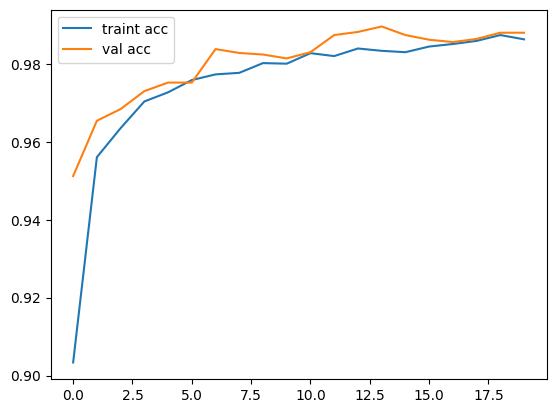

In [15]:
t = [ i.item()  for i in metric["train_acc"]]
v =[ i.item()  for i in metric["val_acc"]]

plt.plot(t,  label= 'traint acc')
plt.plot(v ,  label='val acc')
plt.legend(loc="upper left")
plt.show()


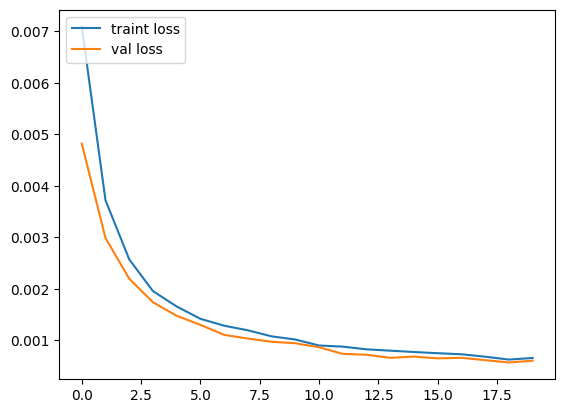

In [16]:
t = [ i.item()  for i in metric["train_loss"]]
v =[ i.item()  for i in metric["val_loss"]]

plt.plot(t,  label= 'traint loss')
plt.plot(v ,  label='val loss')
plt.legend(loc="upper left")
plt.show()

In [17]:
torch.save(model.state_dict(), WORK_ROOT+'/best.pt')

Потом обучил свою CNN. 

Что сказать, надо много эпох, я тестил 30, 50 эпох, оно все равно не так хорошо сходится к хорошим результатам, надо больше эпох, ну или продумать грамотнее структуру сети

In [18]:
model = MyNex().cuda()
model, metric = train_model(model, criterion, optimizer, exp_LR_scheduler, num_epochs=30)

epoch 1/20
**********
training Loss: 0.0109 Acc: 0.5099
validation Loss: 0.0110 Acc: 0.5158
epoch 2/20
**********
training Loss: 0.0109 Acc: 0.5116
validation Loss: 0.0110 Acc: 0.5130
epoch 3/20
**********
training Loss: 0.0109 Acc: 0.5099
validation Loss: 0.0110 Acc: 0.5132
epoch 4/20
**********
training Loss: 0.0109 Acc: 0.5109
validation Loss: 0.0110 Acc: 0.5160
epoch 5/20
**********
training Loss: 0.0109 Acc: 0.5120
validation Loss: 0.0110 Acc: 0.5186
epoch 6/20
**********
training Loss: 0.0109 Acc: 0.5092
validation Loss: 0.0110 Acc: 0.5130
epoch 7/20
**********
training Loss: 0.0109 Acc: 0.5134
validation Loss: 0.0110 Acc: 0.5152
epoch 8/20
**********
training Loss: 0.0109 Acc: 0.5081
validation Loss: 0.0110 Acc: 0.5160
epoch 9/20
**********
training Loss: 0.0109 Acc: 0.5080
validation Loss: 0.0110 Acc: 0.5164
epoch 10/20
**********
training Loss: 0.0109 Acc: 0.5090
validation Loss: 0.0110 Acc: 0.5124
epoch 11/20
**********
training Loss: 0.0109 Acc: 0.5103
validation Loss: 0.011

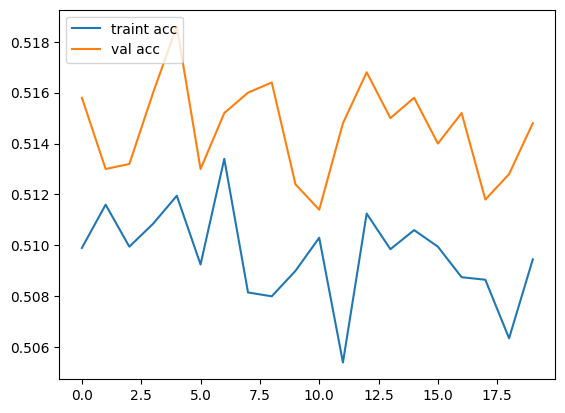

In [19]:
t = [ i.item()  for i in metric["train_acc"]]
v =[ i.item()  for i in metric["val_acc"]]

plt.plot(t,  label= 'traint acc')
plt.plot(v ,  label='val acc')
plt.legend(loc="upper left")
plt.show()


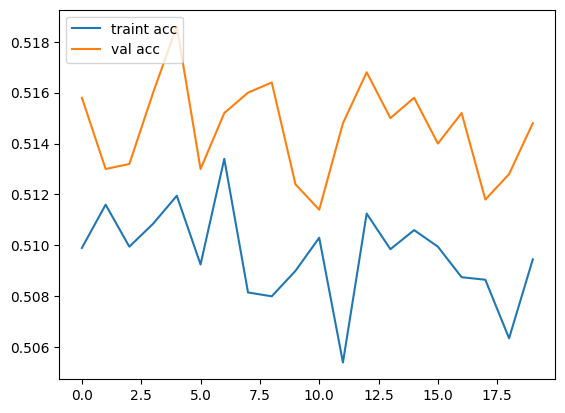

In [20]:
t = [ i.item()  for i in metric["train_acc"]]
v =[ i.item()  for i in metric["val_acc"]]

plt.plot(t,  label= 'traint acc')
plt.plot(v ,  label='val acc')
plt.legend(loc="upper left")
plt.show()


Далее идет классический ML
1. Логрег и кнн просто очень простые алгоритмы
2. градиентный бустинг  потому что очень хороший ансамбли. 
3. метод опорнх векторов, потому что он , из опыта, хорошо решает CV задачи

гиперпараметры не подбирал, да и выборка мелкая была. потому что в оперативу не влазило много
 
Вообще если так подумать, аугментировать данные для svm и размер обучающей выборки увеличить, то можно конкурировать даже сверточными глубокими сетями

In [21]:
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn import svm


In [22]:
from skimage.transform import resize 
from skimage.io import imread 
flat_data_arr=[] 
target_arr=[] 
l =  {'dog': 0, 'cat': 1}

datadir=f'{IMGS_ROOT}/train/' 

for img in filenames[:500]: 
        img_array=imread(datadir+img) 
        
        img_resized=resize(img_array,(244,244,3)) 
        img_resized = np.array(img_resized / 255, dtype='float32')
        flat_data_arr.append(img_resized.flatten()) 
        target_arr.append(l[img[:3]]) 
flat_data=np.array(flat_data_arr) 
target=np.array(target_arr)


In [23]:
df=pd.DataFrame(flat_data)  
df['Target']=target 
df.shape

(500, 178609)

In [24]:
x=df.iloc[:,:-1]  
y=df.iloc[:,-1]
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.10)  

In [25]:
LogReg = LogisticRegression()
knnc_grid_search = KNeighborsClassifier(n_neighbors = 7)
svc_random_search = svm.SVC(random_state=8)
gbc__random_search = GradientBoostingClassifier(n_estimators = 10)




In [26]:
knnc_grid_search.fit(x_train,y_train);print('knn')
LogReg.fit(x_train,y_train);print('log')
gbc__random_search.fit(x_train,y_train);print('gbc')
svc_random_search.fit(x_train,y_train);print('svc')




knn
log
gbc
svc


In [27]:
d = [{'Model': 'gbc',      
      'val Set Accuracy': accuracy_score(y_test,gbc__random_search.predict(x_test)),
      'val Set Precision': precision_score(y_test,gbc__random_search.predict(x_test)),
      'val Set Recall': recall_score(y_test,gbc__random_search.predict(x_test)),
      'val Set f1_score': f1_score(y_test,gbc__random_search.predict(x_test))
     },
     
    {'Model': 'knn',     
     'val Set Accuracy': accuracy_score(y_test,knnc_grid_search.predict(x_test)),
     'val Set Precision': precision_score(y_test,knnc_grid_search.predict(x_test)),
      'val Set Recall': recall_score(y_test,knnc_grid_search.predict(x_test)),
      'val Set f1_score': f1_score(y_test,knnc_grid_search.predict(x_test))}, 

      {'Model': 'LogReg',     
     'val Set Accuracy': accuracy_score(y_test,LogReg.predict(x_test)),
      'val Set Precision': precision_score(y_test,LogReg.predict(x_test)),
      'val Set Recall': recall_score(y_test,LogReg.predict(x_test)),
      'val Set f1_score': f1_score(y_test,LogReg.predict(x_test))}, 


     {'Model': 'svc',
     'val Set Accuracy': accuracy_score(y_test,svc_random_search.predict(x_test)),
     'val Set Precision': precision_score(y_test,svc_random_search.predict(x_test)),
      'val Set Recall': recall_score(y_test,svc_random_search.predict(x_test)),
      'val Set f1_score': f1_score(y_test,svc_random_search.predict(x_test))}, 
]

df_models = pd.DataFrame(d)
#df_models.sort_values('val Set ', ascending=False)
df_models

,Model,val Set Accuracy,val Set Precision,val Set Recall,val Set f1_score
0,gbc,0.54,0.555556,0.576923,0.566038
1,knn,0.60,0.588235,0.769231,0.666667
2,LogReg,0.58,0.571429,0.769231,0.655738
3,svc,0.74,0.696970,0.884615,0.779661


ну судя про пресижону, то можно скзаать так, что это отношение определнных положительных к ко всем определнным.
за рекол  скажу, что способность находит большинство положительных
F1 показывает баланс между толчность и полнотой. то есть чем выше тем лучше
ну экураси чем больше знаение, тем меньше ошибок делает алгоритм

Если смотреть на датафрейм, то вектора показываю хорошие результаты пусть даже не маленькой выборке. Если увелилить ввыборку, подобрать гиперпараметры, то я думаю что она составит хорошую конкуренцию resnet